<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the forward Kolmogorov equation derived in *Craske J. et al. 2024* to the case of 1D scalar diffusion with boundary conditions prescribed by an Ornstein-Ulhenbeck process. The diffusion equation is solved using the open source pseudo-spectral code [Dedalus](https://dedalus-project.org/) (*Burns K.J. et. al. 2020*), while the relevant terms in the forward Kolmogorov equation are estimated using histograms.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [ ]:
# # Set environment variables for best performance
# %env OMP_NUM_THREADS=1
# %env NUMEXPR_MAX_THREADS=1

# # Minimize logging output
# import logging
# logging.disable(logging.DEBUG)

# # Check if running on google colab
# import os
# using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# # Check for Dedalus
# try:
#     import dedalus.public as de
#     print("Dedalus already installed :)")
# except:
#     print("Dedalus not installed yet.")
#     if using_google_colab:
#         print("Installing for Google Colab.")
#         print()
#         # Step 1: Install FFTW
#         !apt-get install libfftw3-dev
#         !apt-get install libfftw3-mpi-dev
#         # Step 2: Set paths for Dedalus installation
#         import os
#         os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
#         os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
#         os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
#         os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
#         # Step 3: Install Dedalus using pip
#         !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
#         !pip3 install -q ipympl
#         # Step 4: Check installation
#         print()
#         try:
#             import dedalus.public as de
#             print("Dedalus successfully installed :)")
#         except:
#             print("Error installing Dedalus :(")
#             raise
#     else:
#         print("See website for installation instructions:")
#         print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# # Setup interactive matplotlib
# if using_google_colab:
#     from google.colab import output
#     output.enable_custom_widget_manager()


**Content**

First let's import everything we need to run the rest of the notebook.

In [3]:
import numpy as np
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)


Next we write a solver for the equation for the scalar concentration
\begin{equation}
\partial_t Y = \Delta_z Y, \quad z \in [0,1],
\end{equation}
subject to the boundary conditions prescribed by the stochastic differential equation
\begin{equation}
 dY_t = a(\mu_z - Y_t) \frac{dt}{T_L} + \left( \frac{2 \sigma^2}{T_L} \right)^{1/2} dW_t , \quad \text{at} \quad z = 0,1, \\
\end{equation}
where $\mu_z$ denote the mean value of the scalar on the left and right hand boundaries respectively, $T_L$ the time-scale at which $Y_t$ at the boundary relaxes towards the mean and $a,\sigma$ are drift and diffusion coefficients. The steady state solution to the Fokker-Planck equation corresponding to this SDE is given by the normal distribution $h_z = \mathcal{N}(\mu_z,\sigma^2)$.

In [5]:
a=1;
σ=1;
T_L=1;

# Boundary conditions
def BC(Y_t,dt,μ_z=1):
    
    return Y_t + a*(μ_z - Y_t)*dt/T_L + dW_t*( 2* σ**2 / T_L)**(1/2)

# Solver
def Solve(Nz=512):

  stop_sim_time = 1
  timestep      = 1e-03

  zcoord = d3.Coordinate('z')
  dist   = d3.Distributor(zcoord, dtype=np.float64)
  zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

  # Fields
  C      = dist.Field(name='c', bases=zbasis)
  tau_c1 = dist.Field(name='tau_c1')
  tau_c2 = dist.Field(name='tau_c2')
  g0     = dist.Field(name='g0')
  g1     = dist.Field(name='g1')

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)
  Cz = dz(C)  + lift(tau_c1)
  Czz= dz(Cz) + lift(tau_c2)

  # Problem
  problem = d3.IVP([C, tau_c1, tau_c2], namespace=locals())
  problem.add_equation("dt(C) - Czz = 0")
  problem.add_equation("C(z=0) = 1")
  problem.add_equation("C(z=1) = 0")

  # Solver
  solver = problem.build_solver(d3.RK222)
  solver.stop_sim_time = stop_sim_time

  # Initial condition
  z      = dist.local_grid(zbasis)
  C['g'] = np.sin(2*np.pi*z)

  # Flow properties
  flow = d3.GlobalFlowProperty(solver, cadence=500)
  flow.add_property(d3.Integrate(C) , name='<C>')
  flow.add_property(d3.Integrate(C**2) , name='<C^2>')
  flow.add_property(d3.Integrate(Cz**2), name='<Cz^2>')

  # Main loop
  logger.info('Starting main loop')
  while solver.proceed:

      Ct_0 = C(z=0).evaluate()['g'][0]
      Ct_1 = C(z=1).evaluate()['g'][0]

      print(Ct_0,Ct_1)
      
      # Specify the bcs
      # g0['g'] = BC(Ct_0,timestep,μ_z=1)
      # g1['g'] = BC(Ct_1,timestep,μ_z=0)

      solver.step(timestep)
      if (solver.iteration-1) % int(stop_sim_time/(4.*timestep)) == 0:

          C_avg   = flow.grid_average('<C>')
          C2_avg  = flow.grid_average('<C^2>')
          Cz2_avg = flow.grid_average('<Cz^2>')

          logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
          logger.info('<C>=%f, <C^2>=%f, <Cz^2>    =%f'%(C_avg,C2_avg,Cz2_avg))

      # Capture the last 5 snapshots
      if  solver.iteration == int(stop_sim_time/timestep) - 5:
          snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
          snapshots.add_task(C , layout='g',name='C' ,scales=3/2)
          snapshots.add_task(Cz, layout='g',name='Cz',scales=3/2)

  return None

The forward Kolmogorov equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f = -\frac{\partial}{ \partial c} \left( \mathbb{D}^{(1)} f \right) + \frac{\partial^2 }{ \partial c^2} \left( \mathbb{D}^{(2)} f \right),
\end{equation}
where
\begin{equation}
\mathbb{D}^{(1)} = \mathbb{E}_{C_t}[\boldsymbol{n} \cdot \nabla C_t ] \frac{h}{f}, \quad\quad \mathbb{D}^{(2)} = -\mathbb{E}_{C_t}[|\nabla C|^2],
\end{equation}
and $h(c;t)$ corresponds to the (unnormalised) density when $C_t$ is sampled from the boundary of the domain and $f(c;t)$ is the global probability density function. This density describes the probability of finding a scalar concentration $c$ at a time $t$ in the interval $z \in [0,1]$. Having time integrated the transport equation for the solute concentration we have a set of snapshots $C(z,t)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we now use this data to calculate the terms in this equation.

In [6]:
def Data():

  # Data loading
  file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

  # Interpolate the data (t,z) from a Chebyshev grid onto a uniform grid
  C_cheb  = file['tasks/C' ][:,:]
  Cz_cheb = file['tasks/Cz'][:,:]
  z_cheb  = file['tasks/C'].dims[1][0][:]
  times   = file['tasks/C'].dims[0][0][:]

  dz_cheb = z_cheb[1]-z_cheb[0];
  z_data  = np.arange(0,1,dz_cheb);
  s       = (len(times),len(z_data));
  C_data  = np.zeros(s)
  Cz_data = np.zeros(s)
  for i,t in enumerate(times):
    C_data[i,:] = np.interp(z_data, z_cheb, C_cheb[i,:] )
    Cz_data[i,:]= np.interp(z_data, z_cheb, Cz_cheb[i,:])
  dC2_data = Cz_data**2;

  return times, z_data,C_data,Cz_data,dC2_data;

*Time derivative*

To evaluate the left hand side we estimate the pdf $f$ (using a histogram) and then compute its time derivative $\partial_t f$ using central differences.

In [7]:
def dfdt(times,C_data,N_bins=128):

  # PDF f_C
  f_np1,c = np.histogram(C_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)
  f_nm1,c = np.histogram(C_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
  c       = 0.5*(c[1:] + c[:-1]); dc = c[1] - c[0];

  # Time derivate df_C/dt
  dt   =  times[-1] - times[-2];
  dfdt = (f_np1 - f_nm1)/2.
  dfdt /=dt;

  return dfdt;

*Diffusion Coefficient*

For the right hand side we first compute the diffusion coefficient
\begin{equation}
\mathbb{D}^{(2)} \equiv -\mathbb{E}_{C_t}[|\nabla C_t|^2] = -\int \phi \frac{ f(\phi,c,t) }{f(c,t)} d \phi, \quad \text{where} \quad \phi = |\nabla C_t|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram. Subsequently we create the derivative operator $L = \partial^2_s$ using central differences. Having used central differencing to estimate the time derivative centered at time index n=-3 we must evaluate this conditional expectation at the same index.

In [8]:
def diffusion(dC2_data,C_data,N_bins=128):

  # Expectation
  # Let Φ = |∇C|^2 and φ its dummy variable
  f_CΦ,c,φ = np.histogram2d(C_data[-3,...].flatten(), dC2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  c = .5*(c[1:]+c[:-1]); dc = c[1] - c[0];
  f_C =  np.sum(  f_CΦ,axis=1)*dφ;      # f_C(c)
  E   = (np.sum(φ*f_CΦ,axis=1)*dφ)/f_C; # E{Φ|C} = int_φ f_Φ|C(φ|c)*φ dφ

  return E,f_C,c

def Laplacian(c):

  N = len(c)
  dc= c[1]-c[0]
  L = np.zeros((N,N))
  for i in range(N):

    if i == 0:
        L[i,i  ] = -2.
        L[i,i+1] =  1
    elif i == N-1:
        L[i,i-1] =  1.
        L[i,i  ] = -2
    else:
        L[i,i-1] =  1
        L[i,i  ] = -2.
        L[i,i+1] =  1

  L   *= 1./(dc**2);
  return L;

*Drift coefficient*

The drift coefficient for this one dimensional case reduces to
\begin{equation}
\mathbb{D}^{(1)} = \frac{1}{f} \Bigl( \mathbb{E}_{C_t}[ \partial_z C_t|_{z=1}] h(c|z=1,t) - \mathbb{E}_{C_t}[\partial_z C_t|_{z=0} ]h(c|z=0,t) \Bigr)
\end{equation}
where the (unnormalised) density $h$ when $C_t$ is sampled from the boundary is given by
\begin{equation}
h(c|z=1,t) = \delta(c - C_t(z=1)), \quad h(c|z=0,t) = \delta(c - C_t(z=0)).
\end{equation}
This follows from the fact that at the end points of our domain which is an interval $C_t$ can take one value only.

For *Dirichlet $\beta = 0$* boundary conditions we know $C_t$ and thus $h$, but we do not know $\partial_z C_t$. Calculating $\mathbb{D}^{(1)}$ reduces to
\begin{equation}
\mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=1}] = \mathbb{E} \left[ \partial_z C_t  \middle| C_t = g_1/\Gamma,Z=1 \right], \quad\quad \mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=0}] = \mathbb{E} \left[ \partial_z C_t  \middle| C_t = g_0/\Gamma,Z=0 \right],
\end{equation}
or more simply $\partial_z C_t$ on the boundaries.

For *Neumann $\Gamma \neq 0$* boundary conditions we know that at the boundaries
\begin{equation}
\mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=1}] = \frac{g_1 - \Gamma c}{\beta}, \quad \mathbb{E}_{C_t}[ \partial_Z C_t|_{Z=0}] = -\frac{g_0 - \Gamma c}{\beta},
\end{equation}
but we do not know $C_t$. As such the task of calculating $D^{(1)}$ reduces to calcultaing the conditional pdf $h$ on the boundaries.

In [9]:
def drift(f_c,c,β,Γ,times):

  file  = h5py.File('snapshots/snapshots_s1.h5', mode='r')
  C_z0  = file['tasks/C' ][-3, 0]
  C_z1  = file['tasks/C' ][-3,-1]

  if β == 0:
    dC_z0 = file['tasks/Cz'][-3, 0]
    dC_z1 = file['tasks/Cz'][-3,-1]
  else:
    dC_z0 = -(g_0(times[-3]) - Γ*C_z0)/β
    dC_z1 = (g_1(times[-3]) - Γ*C_z1)/β

  from numpy import heaviside as H
  int_D1f_C = dC_z1*H(c - C_z1, 1) - dC_z0*H(c - C_z0, 1)

  return int_D1f_C

**Results**

Having computed the terms appearing in the left and right hand sides of the forward Kolmogorov for this advection diffusion problem we now investigate their form as well as validating that the left and right hand sides are equal. The figure below plots (a) the scalar field $C(z,t_n)$, (b) the density and the diffusion coefficient $f, \mathbb{D}^{(2)}$ and (c) the right and left hand sides of the forward Kolmogorov equation.


To avoid artificially smoothing the data in frame (c) we twice integrate the forward Kolmogorov equation with respect to $c$ when comparing the left and right hand side. In particular we treat the drift term analytically using the fact that the fact that
\begin{equation}
\int \mathbb{E}[\phi|C_t = c]h dc  = \int \mathbb{E}[\phi|C_t = c]\delta(c - a) dc =  \mathbb{E}[\phi|C_t = a]H(c - a) + c_1,
\end{equation}
where $H(x)$ denotes the heavisde step function and $c_1$ is a constant.

In [10]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

def Plot_Terms(z_data,C_data,c,f_C,D2,LHS,RHS):

  fig      = plt.figure(layout='constrained',figsize=(12,6))
  subplots = fig.subfigures(1,3, wspace=0.05)

  ax0 = subplots[0].subplots(1,1)
  ax1 = subplots[1].subplots(3,1,sharex=True)
  ax2 = subplots[2].subplots(1,1)

  # ~~~~~~~~~ (a) ~~~~~~~
  ax0.plot(z_data,C_data[-1,:],'k')
  ax0.set_xlim([0,1])
  ax0.set_xlabel(r'$z$',fontsize=20)
  ax0.set_ylabel(r'$C(z,t_n)$',fontsize=20)

  # ~~~~~~~~~ (b) ~~~~~~~
  ax1[0].plot(c,f_C,'r', linewidth=2,label=r'$f(c,t_n)$')
  ax1[0].fill_between(x=c,y1=f_C,color= "r",alpha= 0.2)
  #ax1[0].set_ylim([0.,1.1*np.max(f_C)])

  from scipy.stats import norm

  file    = h5py.File('snapshots/snapshots_s1.h5', mode='r')
  C_z0  = file['tasks/C' ][-3, 0]
  C_z1  = file['tasks/C' ][-3,-1]
  dC_z0 = file['tasks/Cz'][-3, 0]
  dC_z1 = file['tasks/Cz'][-3,-1]

  D1 = (κ/f_C)*( dC_z1*norm.pdf(c,loc=C_z1,scale=0.002) - dC_z0*norm.pdf(c,loc=C_z0,scale=0.002) )

  ax1[1].plot(c,D1,'b', linewidth=2,label=r'$D^{(1)}$')
  ax1[2].plot(c,D2,'b', linewidth=2,label=r'$D^{(2)}$')

  for ax in ax1:
    #ax.set_xlim([1.05*np.min(c),1.05*np.max(c)])
    ax.legend(loc=8,fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

  ax1[2].set_xlabel(r'$c$',fontsize=24)

  # ~~~~~~~~~ (c) ~~~~~~~
  ax2.plot(c,LHS,'r-',label=r'$\int \int ( \partial_t f) dcdc$')
  ax2.plot(c,RHS,'b-',label=r'$-\int ( \mathbb{D}^{(1)} f ) dc + D^{(2)} f $')
  ax2.set_xlabel(r'$c$',fontsize=24)
  #ax2.set_xlim([np.min(c),np.max(c)])
  #ax2.set_ylim([np.min(LHS),1.1*np.max(LHS)])
  ax2.legend(loc=8,fontsize=16)

  for n,ax in enumerate([ax0,ax2]):
      ax.tick_params(axis='x', labelsize=20)
      ax.tick_params(axis='y', labelsize=20)

  plt.savefig('1D_Diffusion.png',dpi=200)
  plt.show()

  return None;

ModuleNotFoundError: No module named 'ipympl'

*Dirichelt Validation $\beta=0$*

In [12]:

# Solve & grab the data
Solve(Nz=64)
times, z_data,C_data,Cz_data,dC2_data = Data()

# Estimate the terms
df_cdt    = dfdt(times   ,C_data)
E,f_C,c   = diffusion(dC2_data,C_data)
D2        = -E
int_D1f_C = drift(f_C,c,β,Γ,times)

L   = Laplacian(c);
LHS = np.linalg.solve(L,df_cdt)
RHS = -int_D1f_C + D2*f_C

Plot_Terms(z_data,C_data,c,f_C,D2,LHS,RHS)

2024-04-24 17:45:00,915 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s


2024-04-24 17:45:00,916 __main__ 0/1 INFO :: Starting main loop
[-2.50255848e-16] [-8.0536736e-16]
2024-04-24 17:45:01,007 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03
2024-04-24 17:45:01,007 __main__ 0/1 INFO :: <C>=-0.000000, <C^2>=0.500000, <Cz^2>    =19.739209
[1.] [2.22044605e-15]
[1.] [-1.88737914e-15]
[1.] [3.99680289e-15]
[1.] [-3.88578059e-16]
[1.] [4.4408921e-15]
[1.] [2.72004641e-15]
[1.] [4.99600361e-16]
[1.] [1.16573418e-15]
[1.] [1.94289029e-15]
[1.] [-6.10622664e-16]
[1.] [1.83186799e-15]
[1.] [1.44328993e-15]
[1.] [6.66133815e-16]
[1.] [3.33066907e-16]
[1.] [2.83106871e-15]
[1.] [3.66373598e-15]
[1.] [2.77555756e-15]
[1.] [1.83186799e-15]
[1.] [6.10622664e-16]
[1.] [-8.8817842e-16]
[1.] [9.43689571e-16]
[1.] [-3.33066907e-16]
[1.] [5.55111512e-16]
[1.] [4.5519144e-15]
[1.] [2.22044605e-16]
[1.] [2.33146835e-15]
[1.] [7.77156117e-16]
[1.] [2.99760217e-15]
[1.] [2.22044605e-16]
[1.] [8.8817842e-16]
[1.] [2.22044605e-16]
[1.] [-1.05471187e-15]
[1.] 

NameError: name 'Plot_Terms' is not defined

*Neumann Validation $\Gamma = 0$*

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


2024-04-22 11:19:24,050 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


INFO:__main__:Starting main loop


2024-04-22 11:19:24,058 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-04-22 11:19:24,758 solvers 0/1 INFO :: Simulation stop time reached.


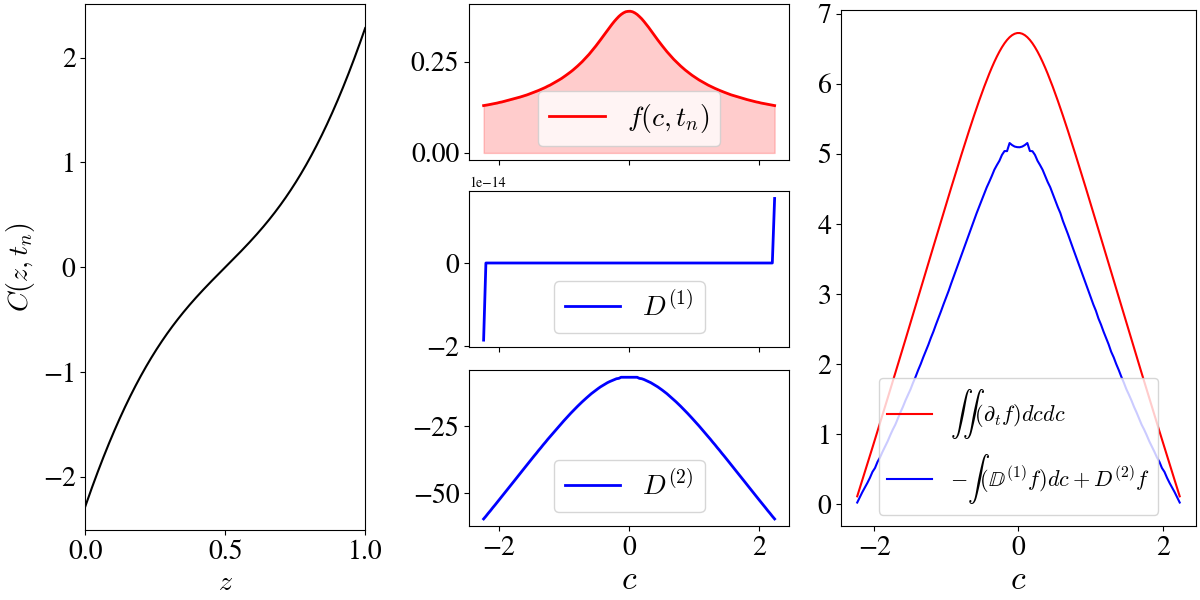

In [220]:
# Parameters
β = 0.1;
Γ = 0.1;

# Solve & grab the data
Solve(β, Γ, Nz=512)
times, z_data,C_data,Cz_data,dC2_data = Data()

# Estimate the terms
df_cdt    = dfdt(times   ,C_data)
E,f_C,c   = diffusion(dC2_data,C_data)
D2        = -E
int_D1f_C = drift(f_C,c,β,Γ,times)

L   = Laplacian(c);
LHS = np.linalg.solve(L,df_cdt)
RHS = -int_D1f_C + D2*f_C

Plot_Terms(z_data,C_data,c,f_C,D2,LHS,RHS)